In [2]:
class Node:
    def __init__(self, id, total_distance, ugv_energy, uav_energy, distance_to_next, radius=None, total_time=None, level=0):
        self.id = id
        self.total_distance = total_distance
        self.ugv_energy = ugv_energy
        self.uav_energy = uav_energy
        self.distance_to_next = distance_to_next
        self.radius = radius
        self.total_time = total_time  # Total time taken to reach this node
        self.level = level
        self.children = []

    def add_child(self, node):
        node.level = self.level + 1  # Set child's level based on parent's level
        self.children.append(node)
        
    def delete_child(self, node):
        if node in self.children:
            self.children.remove(node)

    def display(self):
        print(f"Node ID: {self.id}, Total Distance: {self.total_distance}, UGV Energy: {self.ugv_energy}, UAV Energy: {self.uav_energy}, Distance to Next: {self.distance_to_next}, Radius: {self.radius}, Total Time: {self.total_time}")

    def traverse(self):
        self.display()
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes
    def ucb1(self, exploration_constant=1.41):
        if self.visit_count == 0:
            return float('inf')
        parent_visits = self.parent.visit_count if self.parent is not None else 1
        return self.value / self.visit_count + exploration_constant * math.sqrt(
            math.log(parent_visits) / self.visit_count)

    def best_child(self):
        return min(self.children.values(), key=lambda node: node.ucb1(), default=None)

    def fully_expanded(self):
        return len(self.radius_sequence) == len(waypoints) - 1  # -1 since the sequence length is one less than waypoints

    def update(self, reward):
        self.visit_count += 1
        self.value += reward


In [3]:
def tsp_output_to_tree(tsp_output, waypoints, radii, time_between_nodes, max_total_time):
    nodes_in_order = tsp_output.split()
    nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]

    # Create root node (start)
    root = Node(id=0, total_distance=0, ugv_energy=100, uav_energy=100, distance_to_next=0, radius=None, total_time=0)
    
    # Global counter for node ID
    node_counter = [1]  # Using a list so it's mutable inside nested functions

    def add_node(parent, waypoint_index):
        if waypoint_index >= len(nodes_in_order):
            return

        distance = np.linalg.norm(np.array(waypoints[nodes_in_order[waypoint_index-1]]) - np.array(waypoints[nodes_in_order[waypoint_index]]))
        
        for r in radii:
            modified_distance = distance + r
            ugv_energy = parent.ugv_energy - modified_distance
            uav_energy = parent.uav_energy - modified_distance
            total_time = parent.total_time + time_between_nodes + r

            if ugv_energy > 0 and uav_energy > 0 and total_time <= max_total_time:
                child = Node(id=node_counter[0], total_distance=parent.total_distance + modified_distance, ugv_energy=ugv_energy, uav_energy=uav_energy, distance_to_next=modified_distance, radius=r, total_time=total_time)
                parent.add_child(child)
                node_counter[0] += 1  # Increment global node ID counter
                add_node(child, waypoint_index + 1)

    add_node(root, 1)

    return root


In [5]:
import random
import numpy as np
def generate_waypoints(num_waypoints=5, x_limit=50, y_limit=50):
    """
    Generate random waypoints.
    """
    return [(random.randint(0, x_limit), random.randint(0, y_limit)) for _ in range(num_waypoints)]

def generate_plan_output(num_waypoints):
    """
    Generate a random plan_output string for testing purposes.
    """
    order = list(range(num_waypoints))
    random.shuffle(order)
    plan_output = "Route for vehicle 0:\n"
    for idx in order:
        plan_output += f" {idx} ->"
    plan_output = plan_output.rstrip("->")
    plan_output += f" {order[0]}\n"
    return plan_output

# Test data generation:
NUM_WAYPOINTS = 3
waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
radius = 5
TIME_BETWEEN_NODES = 1
MAX_TIME_LIMIT = 20

# Print generated test data:
print("Waypoints:", waypoints)
print("\nPlan Output:")
print(plan_output)
print("Radius:", radius)
print("Time between nodes:", TIME_BETWEEN_NODES)
print("Max Time Limit:", MAX_TIME_LIMIT)


Waypoints: [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]

Plan Output:
0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0
Radius: 5
Time between nodes: 1
Max Time Limit: 20


In [6]:
def generate_radii(num_radii=5, max_radius=10):
    """
    Generate a set of radii for testing.
    """
    return random.sample(range(1, max_radius + 1), num_radii)

# Test data generation for radii:
NUM_RADII = 3
MAX_RADIUS_VALUE = 10
radii = generate_radii(NUM_RADII, MAX_RADIUS_VALUE)

# Print generated radii:
print("Generated Radii:", radii)


Generated Radii: [8, 4, 5]


In [7]:
waypoints

[(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]

In [8]:
root = tsp_output_to_tree(plan_output, waypoints, radii, 1, MAX_TIME_LIMIT)

In [9]:
root.traverse()

Node ID: 0, Total Distance: 0, UGV Energy: 100, UAV Energy: 100, Distance to Next: 0, Radius: None, Total Time: 0
Node ID: 1, Total Distance: 20.165525060596437, UGV Energy: 79.83447493940356, UAV Energy: 79.83447493940356, Distance to Next: 20.165525060596437, Radius: 8, Total Time: 9
Node ID: 2, Total Distance: 70.92064171346033, UGV Energy: 29.079358286539666, UAV Energy: 29.079358286539666, Distance to Next: 50.7551166528639, Radius: 8, Total Time: 18
Node ID: 3, Total Distance: 66.92064171346033, UGV Energy: 33.079358286539666, UAV Energy: 33.079358286539666, Distance to Next: 46.7551166528639, Radius: 4, Total Time: 14
Node ID: 4, Total Distance: 98.2153298413727, UGV Energy: 1.7846701586273035, UAV Energy: 1.7846701586273035, Distance to Next: 31.294688127912362, Radius: 4, Total Time: 19
Node ID: 5, Total Distance: 99.2153298413727, UGV Energy: 0.7846701586272999, UAV Energy: 0.7846701586272999, Distance to Next: 32.294688127912366, Radius: 5, Total Time: 20
Node ID: 6, Total D

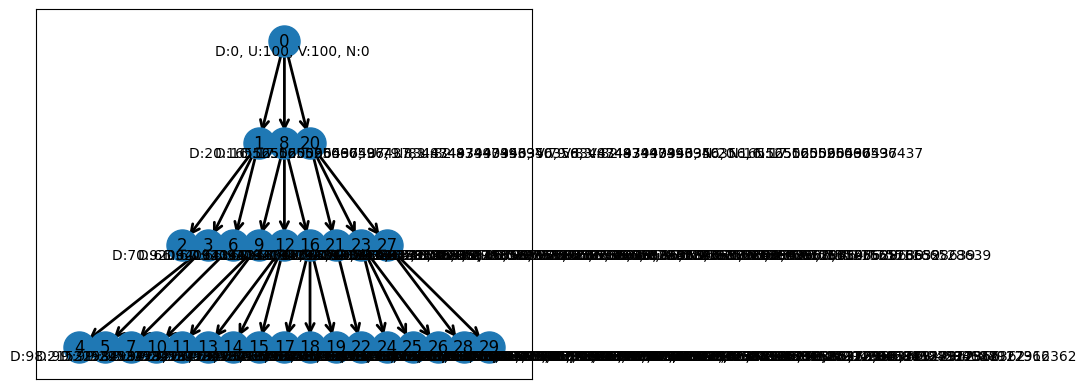

In [12]:
draw_tree(root)

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'D:{node.total_distance}, U:{node.ugv_energy}, V:{node.uav_energy}, N:{node.distance_to_next}',
            xy=pos[node.id], textcoords='offset points', xytext=(-50,-10))

    plt.show()


In [54]:
root = Node(0, 0, 100, 100, 10)
child1 = Node(1, 10, 90, 90, 20)
child2 = Node(2, 30, 80, 80, 15)
child3 = Node(3, 45, 70, 70, 25)
child4 = Node(4, 40, 75, 75, 30)
child5 = Node(5, 30, 80, 80, 50)
child6 = Node(6, 30, 80, 80, 50)
root.add_child(child1)
root.add_child(child2)
child1.add_child(child3)
child1.add_child(child4)
child2.add_child(child5)
child2.add_child(child6)
# Draw the tree
draw_tree(root)


In [94]:
from graphviz import Digraph

def draw_tree(root):
    dot = Digraph()
    def add_edges(node):
        for child in node.children:
            dot.edge(str(node.id), str(child.id)
                     label=f'D:{child.total_distance}, U:{child.ugv_energy}, V:{child.uav_energy}, N:{child.distance_to_next}')
            add_edges(child)
    add_edges(root)
    dot.view()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1822088987.py, line 7)

In [43]:


# Create nodes and add them to the tree
root = Node(1, 0, 100, 100, 10)
child1 = Node(2, 10, 90, 90, 20)
child2 = Node(3, 30, 80, 80, 15)
child3 = Node(4, 45, 70, 70, 25)

root.add_child(child1)
root.add_child(child2)
child1.add_child(child3)

# Draw the tree
draw_tree(root)


In [99]:
def get_ugv_energy(total_charge, travel_with_drone_mah, travel_without_drone_mah, drone_charge_mah):
    """
    Compute the remaining UGV energy based on the total charge and mAh used.

    Parameters:
    - total_charge: The total available charge in mAh.
    - travel_with_drone_mah: The mAh used for traveling with the drone.
    - travel_without_drone_mah: The mAh used for traveling without the drone.
    - drone_charge_mah: The mAh used to charge the drone.

    Returns:
    - remaining_energy: The remaining UGV energy in mAh.
    """

    used_charge = travel_with_drone_mah + travel_without_drone_mah + drone_charge_mah
    remaining_energy = total_charge - used_charge

    # Ensure that the remaining energy is not negative
    if remaining_energy < 0:
        print("Error: Used more energy than available!")
        return 0

    return remaining_energy

# Example usage:
total_charge = 10000  # 10000 mAh
travel_with_drone_mah = 3000
travel_without_drone_mah = 2000
drone_charge_mah = 2500

remaining_energy = get_ugv_energy(total_charge, travel_with_drone_mah, travel_without_drone_mah, drone_charge_mah)
print(f"Remaining UGV energy: {remaining_energy} mAh")


Remaining UGV energy: 2500 mAh


In [100]:
def get_uav_energy(total_charge, travel_mah, survey_mah, charge_gained_mah):
    """
    Compute the remaining UAV energy based on the total charge, mAh used for traveling, 
    mAh used for the site survey, and mAh gained from charging.

    Parameters:
    - total_charge: The total available charge in mAh.
    - travel_mah: The mAh used for traveling.
    - survey_mah: The mAh used for the site survey.
    - charge_gained_mah: The mAh gained from charging.

    Returns:
    - remaining_energy: The remaining UAV energy in mAh.
    """

    # Compute the total used charge
    total_used_charge = travel_mah + survey_mah - charge_gained_mah

    # Compute the remaining energy
    remaining_energy = total_charge - total_used_charge

    # Ensure that the remaining energy is not negative
    if remaining_energy < 0:
        print("Error: Used more energy than available!")
        return 0

    return remaining_energy

# Example usage:
total_charge = 5000  # 5000 mAh
travel_mah = 3000
survey_mah = 1000
charge_gained_mah = 2000

remaining_energy = get_uav_energy(total_charge, travel_mah, survey_mah, charge_gained_mah)
print(f"Remaining UAV energy: {remaining_energy} mAh")


Remaining UAV energy: 3000 mAh


In [101]:
def expand_tree(parent_node, radius_set, id_start=1):
    """
    Function to expand a tree based on a given radius set. Each element in the radius set represents a child node.

    Parameters:
    parent_node (Node): The parent node to which child nodes will be attached.
    radius_set (list): The set of radius values, each representing a different child node.
    id_start (int): The starting value for child node IDs.

    Returns:
    int: The next ID value to be used for node creation.
    """
    
    for radius in radius_set:
        # Calculate the values for the new node
        total_distance = parent_node.total_distance + radius  # Example calculation
        ugv_energy = parent_node.ugv_energy - radius  # Example calculation
        uav_energy = parent_node.uav_energy - radius  # Example calculation
        distance_to_next = radius  # Example calculation

        # Ensure the energy levels do not drop below 0
        if ugv_energy >= 0 and uav_energy >= 0:
            # Create the new node and add it as a child of the parent node
            child_node = Node(id_start, total_distance, ugv_energy, uav_energy, distance_to_next)
            parent_node.add_child(child_node)

            # Increment the ID for the next node
            id_start += 1

    # Return the next ID to be used
    return id_start

# Example usage:
root = Node(0, 0, 100, 100, 0)  # Create a root node
radius_set = [10, 50, 30 ,100]  # Define the radius set
expand_tree(root, radius_set)  # Expand the tree based on the radius set

# Display the tree
root.traverse()


Node ID: 0, Total Distance: 0, UGV Energy: 100, UAV Energy: 100, Distance to Next: 0, Radius: None, Total Time: None
Node ID: 1, Total Distance: 10, UGV Energy: 90, UAV Energy: 90, Distance to Next: 10, Radius: None, Total Time: None
Node ID: 2, Total Distance: 50, UGV Energy: 50, UAV Energy: 50, Distance to Next: 50, Radius: None, Total Time: None
Node ID: 3, Total Distance: 30, UGV Energy: 70, UAV Energy: 70, Distance to Next: 30, Radius: None, Total Time: None
Node ID: 4, Total Distance: 100, UGV Energy: 0, UAV Energy: 0, Distance to Next: 100, Radius: None, Total Time: None


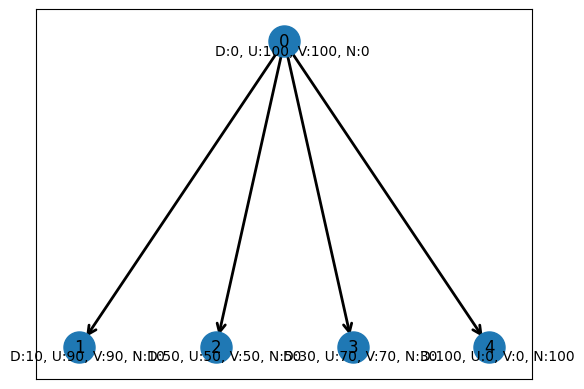

In [102]:
draw_tree(root)